In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
# Import wine dataset from uci as pd data frame
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=";")
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
for key in data.keys():
    print(f"{key} has {len(np.unique(data[key]))} unique values.")

fixed acidity has 96 unique values.
volatile acidity has 143 unique values.
citric acid has 80 unique values.
residual sugar has 91 unique values.
chlorides has 153 unique values.
free sulfur dioxide has 60 unique values.
total sulfur dioxide has 144 unique values.
density has 436 unique values.
pH has 89 unique values.
sulphates has 96 unique values.
alcohol has 65 unique values.
quality has 6 unique values.


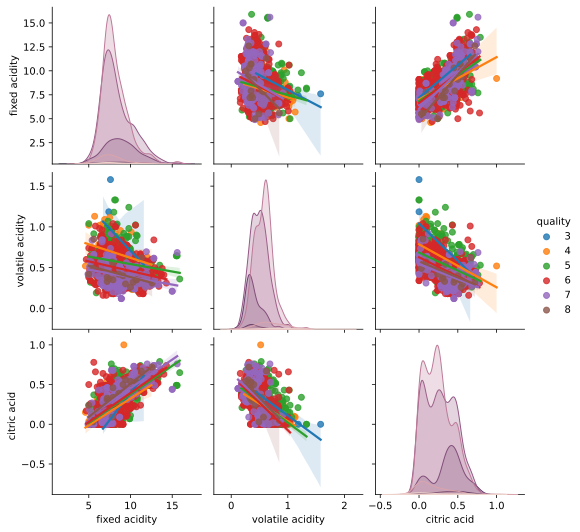

In [5]:
# Pairwise plots
# cols2plot = np.array(data.keys()) # Takes a lot of time to render using sns so pair plotting few columns
cols2plot = ["fixed acidity", "volatile acidity", "citric acid", "quality"]
sns.pairplot(data[cols2plot], kind="reg", hue="quality")
plt.show()

/tmp/ipykernel_141883/1375023110.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


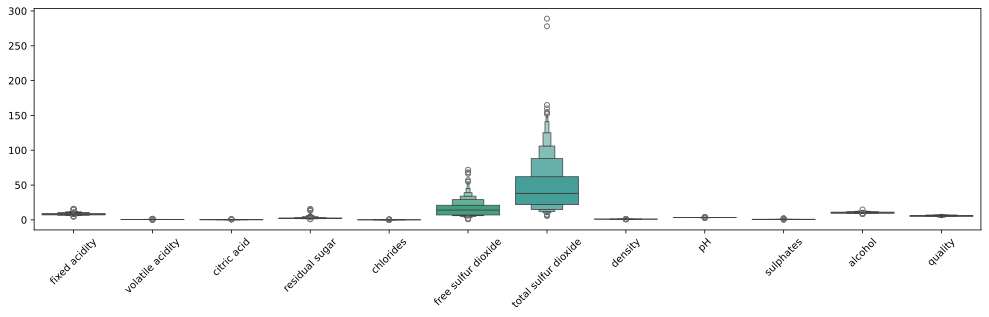

In [6]:
# Box plot to see the data valriations
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxenplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()
# Plot shows a lot of variabelity which is not good for deep learning models

/tmp/ipykernel_141883/1055217218.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


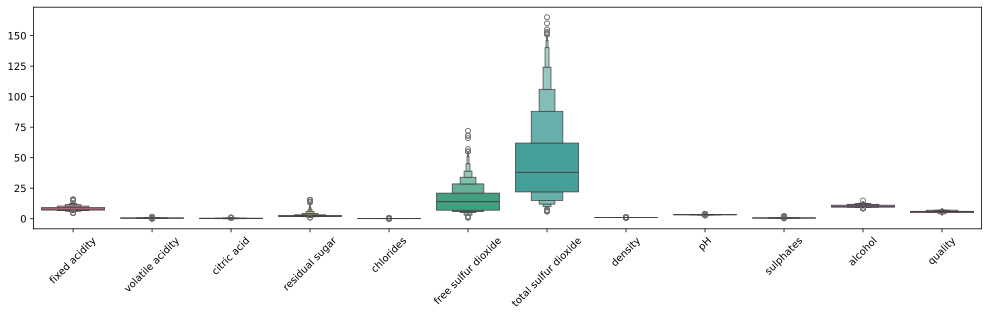

In [7]:
# So let's remove the outliers and re-do the plots
data = data[data["total sulfur dioxide"] < 200]
# Box plot to see the data valriations
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxenplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()
# This is little better but we need to normalize the data

In [8]:
# Data normalization using z-score
### Columns to normalize
cols2zscore = data.keys()
### We don't need to normalize quality as it is the output label
cols2zscore = cols2zscore.drop("quality")
print(f"Columns to normalize: {cols2zscore}")

# Apply z-score manually
# for col in cols2zscore:
#     mean = np.mean(data[col])
#     stdDev = np.std(data[col], ddof=1)
#     data[col] = (data[col] - mean) / stdDev

# Better way to apply z-score
data[cols2zscore] = data[cols2zscore].apply(
    stats.zscore
)  # This has better numerical stabelity

data.describe()

Columns to normalize: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,3.559388e-17,1.245786e-16,1.779694e-17,-9.788316e-17,-1.423755e-16,8.898469e-18,-5.339081e-17,-8.361001e-14,3.025479e-16,8.898469e-17,-5.695020e-16,5.634314
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,0.806630
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,-1.169149e+00,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,3.000000
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,-4.525789e-01,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,5.000000
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,-2.376079e-01,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,6.000000
75%,5.051954e-01,6.253377e-01,7.695258e-01,4.902022e-02,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,6.000000
max,4.352281e+00,5.878672e+00,3.754246e+00,9.292776e+00,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,8.000000


/tmp/ipykernel_141883/2470519472.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


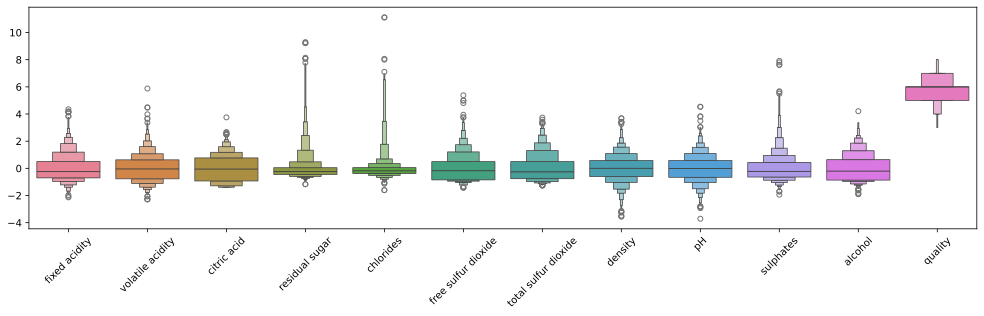

In [9]:
# Let's plot the data again and see the varitions
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxenplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()
# This is much better

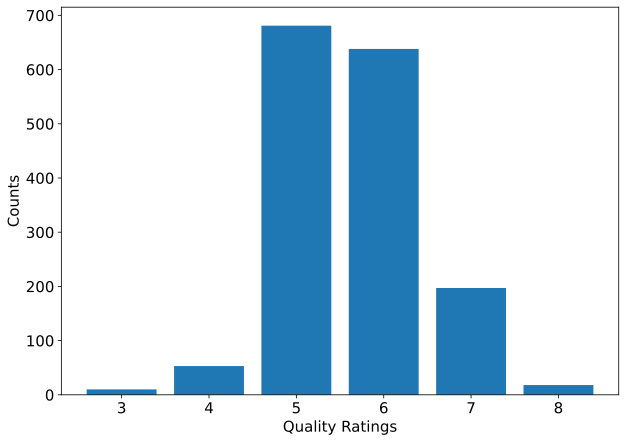

In [ ]:
# Data distribution quality values
fig = plt.figure(figsize=(10, 7))
plt.rcParams.update({"font.size": 15})

counts = data["quality"].value_counts()
plt.bar(list(counts.keys()), counts)
plt.xlabel("Quality Ratings")
plt.ylabel("Counts")
plt.show()